In [1]:
import os
from typing import *

import multiprocess as mp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import edgedroid.data as e_data
from edgedroid.execution_times import *


def process_model(
        mcls: Type[ExecutionTimeModel],
        run_id: int,
        # df: pd.DataFrame,
        # data: pd.DataFrame,
        fade_dist: int,
        samples: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    result = deque()

    # load the data
    params = e_data.load_default_exec_time_data()
    data = preprocess_data(*params, transition_fade_distance=fade_dist)
    raw_data, *_ = params

    # dataframe for participant
    df = raw_data[raw_data["run_id"] == run_id].copy()

    # prepare the model
    neuro = raw_data.iloc[0, df.columns.get_loc("neuroticism")]
    model: ExecutionTimeModel = mcls(data=data, neuroticism=neuro, transition_fade_distance=fade_dist)

    # record task duration
    task_df = pd.DataFrame(index=np.arange(samples), columns=["run_id", "real_task_duration", "model_task_duration"])
    task_df["run_id"] = run_id
    task_df["real_task_duration"] = df["exec_time"].sum()
    task_df["model"] = mcls.__name__

    for i in range(samples):
        model.reset()
        states = deque()

        model_exec_times = np.empty(len(df.index), dtype=np.float64)

        for j, step in enumerate(df.itertuples(index=True)):
            model_exec_times[j] = model.get_execution_time()
            states.append(model.state_info())
            model.set_delay(step.delay)

        result_df = df.copy()
        result_df["model_exec_time"] = model_exec_times
        result_df["sample"] = i
        result_df["model"] = mcls.__name__

        model_df = pd.DataFrame(states)
        result_df = result_df.merge(
            right=model_df.drop(columns=["neuroticism_raw"]),
            on="seq",
            suffixes=["", "_model"]
        )

        result.append(result_df)
        task_df.at[i, "model_task_duration"] = result_df["model_exec_time"].sum()

    trace_df = pd.concat(result, ignore_index=True)
    del result

    task_df["reldiff"] = (task_df["model_task_duration"] - task_df["real_task_duration"]) / task_df["real_task_duration"]
    task_df["fade_distance"] = fade_dist

    # filter outliers using preprocessed data
    # remove the top and bottom 5-percentiles (exec times)
    for _, df in data.groupby(["neuroticism", "impairment", "transition", "duration"]):
        # winsorize
        percs = np.percentile(df.next_exec_time, [5, 95])

        out = df[(df["next_exec_time"] < percs[0]) | (df["next_exec_time"] > percs[1])]
        trace_df = trace_df[~(np.isin(trace_df["run_id"], out["run_id"]) & np.isin(trace_df["seq"], out["seq"]))]

    trace_df = trace_df.copy()
    trace_df["reldiff"] = (trace_df["model_exec_time"] - trace_df["exec_time"]) / trace_df["exec_time"]
    trace_df["fade_distance"] = fade_dist

    return trace_df, task_df


samples = 50

raw_data, *_ = e_data.load_default_exec_time_data()
run_ids = raw_data.run_id.unique()
del raw_data

step_result = deque()
task_result = deque()
workers = os.cpu_count() - 1
for mcls in tqdm((TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel), leave=True, desc="Models"):
    for i, fade_dist in enumerate(tqdm((2, 4, 8, None), leave=True, desc="Fade distance")):
        with tqdm(total=len(run_ids), leave=True, desc="Runs", position=i) as pbar, mp.Pool(workers) as pool:
            fade_result = [
                pool.apply_async(
                    process_model,
                    args=(
                        mcls,
                        rid,
                        fade_dist,
                        samples
                    ),
                    callback=lambda _: pbar.update()
                )
                for rid in run_ids
            ]

            for r in fade_result:
                step_df, task_df = r.get()
                step_result.append(step_df)
                task_result.append(task_df)

            # step_result.extend([r.get() for r in fade_result])

trace_result = pd.concat(step_result, ignore_index=True)
trace_task_result = pd.concat(task_result, ignore_index=True)
del step_result
del task_result

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Fade distance:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Fade distance:   0%|          | 0/4 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

Runs:   0%|          | 0/40 [00:00<?, ?it/s]

In [2]:
trace_result["fade_distance"] = trace_result["fade_distance"].replace({None: -1})
trace_result

,run_id,seq,exec_time,delay,neuroticism,model_exec_time,sample,model,neuroticism_model,delay_model,impairment,transition,duration,duration_raw,reldiff,fade_distance
0,134146,21,3.909,3.000,0.375,4.233450,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",3.000,"[2.0, inf)",NoTransition,"[5.0, 10.0)",6,0.083001,2
1,134146,30,5.421,2.700,0.375,6.015605,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.700,"[2.0, inf)",NoTransition,"[10.0, inf)",15,0.109685,2
2,134146,35,3.392,2.700,0.375,9.089423,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.700,"[2.0, inf)",NoTransition,"[10.0, inf)",20,1.679665,2
3,134146,56,3.556,1.650,0.375,5.223361,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.650,"[1.0, 2.0)",NoTransition,"[10.0, inf)",17,0.468887,2
4,134146,57,7.458,0.000,0.375,3.822111,0,TheoreticalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.650,"[1.0, 2.0)",NoTransition,"[10.0, inf)",18,-0.487515,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934295,137353,125,7.748,1.650,0.625,8.696000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",1.125,"[1.0, 2.0)",Higher2Lower,"[10.0, inf)",12,0.122354,-1
934296,137353,139,8.639,2.175,0.625,8.427000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.175,"[2.0, inf)",Lower2Higher,"[0.0, 5.0)",2,-0.024540,-1
934297,137353,145,5.381,2.175,0.625,4.147000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",2.175,"[2.0, inf)",Lower2Higher,"[5.0, 10.0)",8,-0.229325,-1
934298,137353,154,8.614,3.000,0.625,4.069000,49,EmpiricalExecutionTimeModel,"[0.3333333333333333, 0.6666666666666666)",3.000,"[2.0, inf)",Lower2Higher,"[0.0, 5.0)",1,-0.527629,-1


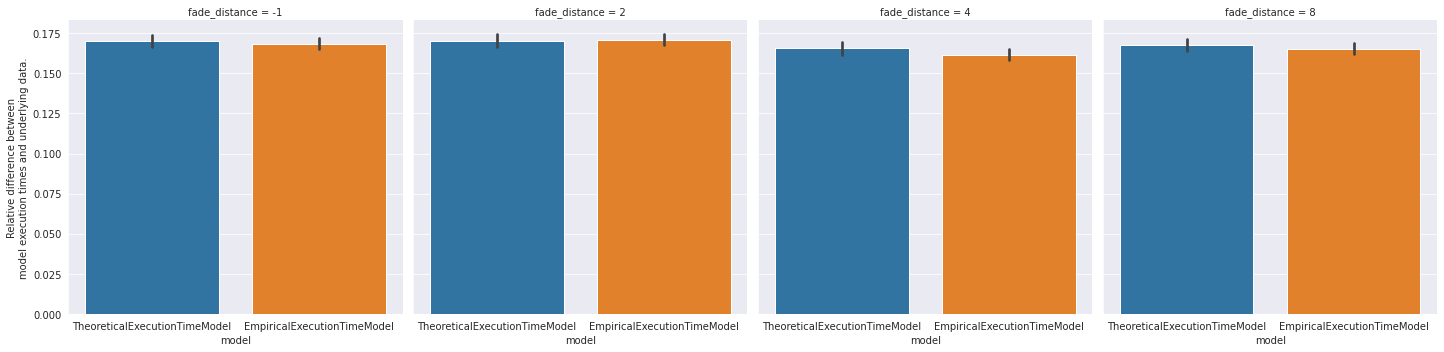

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fg = sns.catplot(
    kind="bar",
    x="model",
    y="reldiff",
    col="fade_distance",
    data=trace_result,
    ci=95
)
fg.set_ylabels("Relative difference between\nmodel execution times and underlying data.")
plt.show()

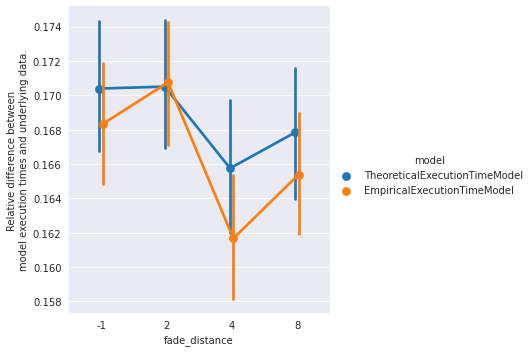

In [12]:
fg = sns.catplot(
    kind="point",
    x="fade_distance",
    y="reldiff",
    hue="model",
    data=trace_result,
    ci=95,
    dodge=True,
    # err_style="bars",
)
fg.set_ylabels("Relative difference between\nmodel execution times and underlying data.")
plt.show()

In [19]:
trace_result.groupby(["model", "fade_distance"])["reldiff"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, .9, .99])

count      mean       std  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1             114250.0  0.168336  0.590044   
                               2             115250.0  0.170754  0.601873   
                               4             114350.0  0.161672  0.591972   
                               8             123300.0  0.165392  0.597694   
TheoreticalExecutionTimeModel -1             114250.0  0.170397  0.660720   
                               2             115250.0  0.170508  0.652433   
                               4             114350.0  0.165756  0.666545   
                               8             123300.0  0.167851  0.665671   

                                                  min        5%       10%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1            -0.759572 -0.531674 -0.447838   
                               2            -0.796435 -0.535205 -0.453747   
                               4            -0.767412 -0.538982 -0.457662   
                               8            -0.785485 -0.538595 -0.454281   
TheoreticalExecutionTimeModel -1            -1.000000 -0.541955 -0.457473   
                               2            -1.000000 -0.538115 -0.452663   
                               4            -1.000000 -0.546691 -0.464166   
                               8            -1.000000 -0.544210 -0.460776   

                                                  25%       50%       75%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1            -0.259970  0.035759  0.457087   
                               2            -0.263375  0.033111  0.458048   
                               4            -0.268110  0.028341  0.451457   
                               8            -0.267163  0.030323  0.452422   
TheoreticalExecutionTimeModel -1            -0.273451  0.013352  0.432185   
                               2            -0.270104  0.016887  0.432436   
                               4            -0.281364  0.005944  0.426835   
                               8            -0.278332  0.008979  0.425187   

                                                  90%       99%        max  
model                         fade_distance                                 
EmpiricalExecutionTimeModel   -1             0.966195  2.086516   4.547062  
                               2             0.973921  2.158609   4.286528  
                               4             0.956693  2.073624   4.571429  
                               8             0.967317  2.122260   4.876651  
TheoreticalExecutionTimeModel -1             0.977315  2.508146  10.813566  
                               2             0.971042  2.466260   8.341014  
                               4             0.976833  2.529396  11.317934  
                               8             0.978513  2.533109  10.608630

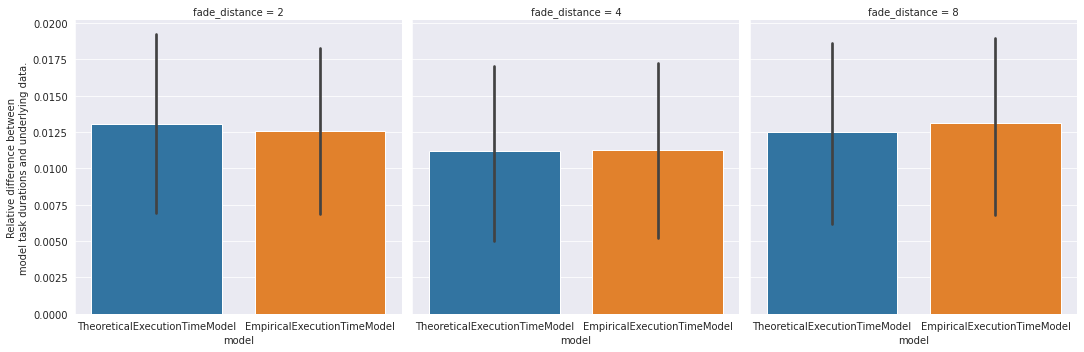

In [4]:
fg = sns.catplot(
    kind="bar",
    x="model",
    col="fade_distance",
    y="reldiff",
    data=trace_task_result,
    ci=95,
)
fg.set_ylabels("Relative difference between\nmodel task durations and underlying data.")
plt.show()

In [30]:
trace_task_result["reldiff"] = trace_task_result["reldiff"].astype(float)
trace_task_result.groupby(["model", "fade_distance"])["reldiff"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, .9, .99])

count      mean       std  \
model                         fade_distance                               
EmpiricalExecutionTimeModel   2              2000.0  0.012572  0.138466   
                              4              2000.0  0.011285  0.137576   
                              8              2000.0  0.013137  0.138501   
TheoreticalExecutionTimeModel 2              2000.0  0.013078  0.139336   
                              4              2000.0  0.011180  0.138662   
                              8              2000.0  0.012532  0.139070   

                                                  min        5%       10%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   2             -0.268353 -0.200955 -0.168736   
                              4             -0.272484 -0.204886 -0.171044   
                              8             -0.287988 -0.201453 -0.167885   
TheoreticalExecutionTimeModel 2             -0.270401 -0.200028 -0.170121   
                              4             -0.283897 -0.200806 -0.171735   
                              8             -0.281564 -0.201386 -0.171439   

                                                  25%       50%       75%  \
model                         fade_distance                                 
EmpiricalExecutionTimeModel   2             -0.099619  0.008701  0.111005   
                              4             -0.099658  0.006554  0.117115   
                              8             -0.097050  0.009443  0.117949   
TheoreticalExecutionTimeModel 2             -0.098380  0.005554  0.116930   
                              4             -0.100415  0.002020  0.115214   
                              8             -0.098832  0.003798  0.114993   

                                                  90%       99%       max  
model                         fade_distance                                
EmpiricalExecutionTimeModel   2              0.212237  0.304783  0.360257  
                              4              0.210662  0.292177  0.356177  
                              8              0.215391  0.297814  0.416035  
TheoreticalExecutionTimeModel 2              0.210576  0.311336  0.388131  
                              4              0.208133  0.308932  0.375731  
                              8              0.211792  0.312932  0.380825

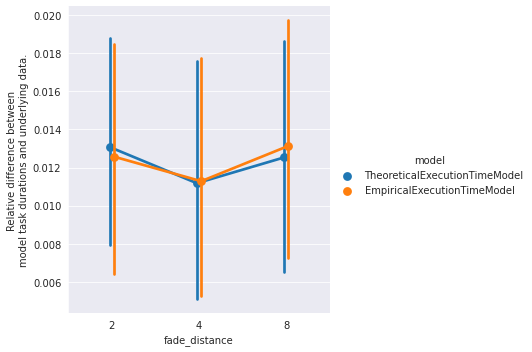

In [14]:
fg = sns.catplot(
    kind="point",
    hue="model",
    x="fade_distance",
    y="reldiff",
    data=trace_task_result,
    ci=95,
    dodge=True,
)
fg.set_ylabels("Relative difference between\nmodel task durations and underlying data.")
plt.show()